images.shape: (106, 100, 100, 3)
poses.shape: (106, 4, 4)
focal.shape: ()
H: 100
W: 100


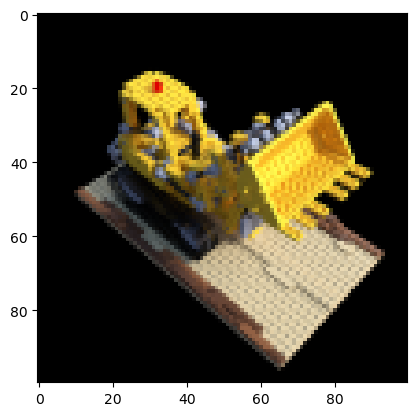

In [45]:
import matplotlib.pyplot as plt
import numpy as np

#加载数据
data = np.load('tiny_nerf_data.npz')
images = data['images'] # 图片
poses = data['poses']# 位姿
focal = data['focal']# 焦距
H,W = images.shape[1:3]# 高和宽
print("images.shape:",images.shape) # images.shape--> N,H,W,3 N代表用于train test val的总数量 ，H,W,3分别代表高 宽 通道数
print("poses.shape:",poses.shape) # 转置矩阵 N，4,4
print("focal.shape:",focal.shape)
print("H:",H)
print("W:",W)
n_train = 100 # 训练使用的照片
test_img, test_pose = images[101],poses[101]
images = images[:n_train] #从加载的数据里面选100个数据来训练使用（原来是106个-->100个
poses = poses[:n_train]
plt.imshow(test_img)
plt.show()

In [21]:

#首先理解论文的MLP结构图，每层为全连接层，并且黑色箭头代表Relu激活，橙色箭头代表没有激活，虚线箭头代表Sigmoid激活(两幅图)，
#输入:在一开始，输入的是经过PE操作(位置编码)的5维坐标(位置+角度)，在第5层再次加入输入，在第8层的时候输出 alpha 值，理解为透明度，在第9层继续加入输入，24维度的， 最后通过sigmoid的激活函数输出rgb值，也可以叫color

from torch import nn
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.nn.functional as F
from tqdm import tqdm

# 构建Nerf 网络结构
class Nerf(nn.Module):
    #D=8 netdepth网络的深度 ,也就是网络的层数 layers in network
    # W=256 netwidth网络宽度 , 也就每一层的神经元的个数 channels per layer
    # input_ch=60 输入的通道,(这里稍微解释下，这里输入的数据是经过位置编码操作的)
    # input_ch_views=24  输入经过PE升维的视角数据
    # skip=4,  用来决定在什么时候加入 视角数据
    # use_view_dirs=True

    def __init__(self,D=8,W=256, input_ch=60,input_ch_views=24,skip=4,use_view_dirs=True):
        self.D=D
        self.W=W
        self.input_ch=input_ch
        self.input_ch_views=input_ch_views
        self.skip=skip
        self.use_view_dirs =use_view_dirs
       #开始编写网络
        self.net =nn.ModuleList([nn.Linear(input_ch,W)])
        for i in range(D-1):
            if i== skip:#在网络的第5层，添加 60维的输入数据  为什么加？？？ 256-->316
                self.net.append(nn.Linear(W+input_ch,W))
            else:
                self.net.append(nn.Linear(W,W))#这里的意思就是传入的数据是W 维，也就是256维，输出也是256维

        self.alpha_linear =nn.Linear(W,1) #输出透明度值的卷积层，由256维输出1维数值
        self.feature_linear = nn.Linear(W,W) # 第9层
        #上面已经完成了 0-7层的卷积层
        if use_view_dirs:# 如果添加使用视角数据，那么在第9层添加24维度的方向数据，并且输出128维的信息
            self.proj = nn.Linear(W+input_ch_views,W//2)
        else:
            self.proj=nn.Linear(W,W//2)# 如果不添加使用视角数据，那么不在第9层添加24维度的方向数据，并且输出128维的信息
        self.rgb_linear = nn.Linear(W//2,3)#在最后一层，输入是128维信息，输出的是 rgb值

    def forward(self, input_pts, input_views=None):
        h = input_pts.clone() # 分别代表 输入的位置信息以及视角信息 or方向信息
#         >>> line = [1,2,3,4,5]
# >>> for i,j in enumerate(line):
# ...     print(i,j)
# ...
# 0 1
# 1 2
# 2 3
# 3 4
# 4 5
          #这里的作用就是依次给相连每层添加激活层
        for i , _ in enumerate(self.net): #这个循环依次返回 net网络的 索引（也就是层数，从0开始） 以及  索引对应的内容
            h = F.relu(self.net[i](h))
            if i == self.skip:# 如果遇到第5层，也就是索引为4的时候
                h == torch.cat([input_pts,h],-1)
        #经过上面8个relu激活层处理，通过最后一个relu层后输出 透明度值
        #forward 函数的作用是将输入数据经过网络中各个层的计算和变换后，得到输出结果 （前向传播计算）
        alpha = F.relu(self.alpha_linear(h))# 这里可以这么理解，h为经过前面7层处理得到的数据，然后传到alpha_linear层，再对拥有h信息的alpha_linear层进行relu处理，输出alpha值
        feature = self.feature_linear #第9个卷积层

        if self.use_view_dirs:# 如果添加视角数据，那么在该层通过torch.cat 将其加入原有的信息， 这里的h理解为经过前面8个卷积层前面传播的结果+24维的视角信息
            h = torch.cat([feature,input_views],-1)

        h =F.relu(self.proj(h))#这里的操作对应于图中 256--》128的激活操作
        #128层的网络层最后通过sigmoid激活函数 输出rgb值
        rgb= torch.sigmoid(self.rgb_linear(h))

        return rgb,alpha

# net = Nerf(use_view_dirs=True)
# print(net)
#
# NeRF(
#   (net): ModuleList(
#     (0): Linear(in_features=60, out_features=256, bias=True)
#     (1): Linear(in_features=256, out_features=256, bias=True)
#     (2): Linear(in_features=256, out_features=256, bias=True)
#     (3): Linear(in_features=256, out_features=256, bias=True)
#     (4): Linear(in_features=256, out_features=256, bias=True)
#     (5): Linear(in_features=316, out_features=256, bias=True)
#     (6): Linear(in_features=256, out_features=256, bias=True)
#     (7): Linear(in_features=256, out_features=256, bias=True)
#   )


# >>> import torch
# >>> x = torch.randn(2,3)
# >>> x
# tensor([[-0.8168, -1.9389,  0.0781],
#         [ 0.3570, -1.3199, -0.1600]])
# >>> torch.cat((x,x),0)
# tensor([[-0.8168, -1.9389,  0.0781],
#         [ 0.3570, -1.3199, -0.1600],
#         [-0.8168, -1.9389,  0.0781],
#         [ 0.3570, -1.3199, -0.1600]])
# >>> torch.cat((x,x),-1)
# tensor([[-0.8168, -1.9389,  0.0781, -0.8168, -1.9389,  0.0781],
#         [ 0.3570, -1.3199, -0.1600,  0.3570, -1.3199, -0.1600]])
#射线经过空间上的每个点的密度（只和空间坐标相关）和颜色（同时依赖空间坐标和入射角）进行某种积分就可以得到每个像素的颜色。当每个像素的颜色都计算出来，那么这个视角下的图像就被渲染出来了

#np.concatenate函数对矩阵在第0维度上做合并操作

In [22]:
def PE(x, L):#位置编码 低频信息转换为高频信息-  x代表输入给编码器的数据维度，也就是3，2,5， l为数学公式中的L
    #这个函数对x坐标的3个值和向量d 的2个值都进行了编码。实验中设置了 L=10 for y(x)，L=4 for y（d）
#这里为了方便统一处理，应该会影响最后效果
    #深度网络更偏向于学习空间中的低频信号。如果对于跳变剧烈的信号（高频），仅仅使用坐标表示作为输入的深度网络是难以拟合的。因此作者将坐标表示通过高频函数映射到了更高维空间中。
  pai = 3.14
  pe = []
  for i in range(L):
    for fn in [torch.sin, torch.cos]:#依次 先后读取sin cos 函数
      pe.append(fn(2.**i * x * pai))
  return torch.cat(pe, -1)  #对tensor 进行拼接

In [35]:
#光线采集 。   屏幕坐标系---》相机坐标系---》世界坐标系

# #射线经过空间上的每个点的密度（只和空间坐标相关）和颜色（同时依赖空间坐标和入射角），对二者进行某种积分就可以得到每个像素的颜色。当每个像素的颜色都计算出来，那么这个视角下的图像就被渲染出来了

#先在三维空间利用几何关系和内参矩阵K求得表示光线方向的向量；
#随后利用外参矩阵将相机坐标系变换到世界坐标系；
def sample_rays_np(H,W,f,c2w):
    #生成网格点坐标矩阵，i，j分别表示每个像素的坐标，i每一行表示x轴坐标，j每行代表y轴坐标
    i,j = np.meshgrid(np.arange(W,dtype=np.float32),np.arange(H,dtype=np.float32),indexing='xy')
   ##利用相机内参 K 计算每个像素坐标相对于光心的单位方向   因为Nerf坐标系和 colmap的坐标系相反的
    dirs = np.stack([(i-W*.5+.5)/f, -(j-H*.5+.5)/f, -np.ones_like(i)],-1)
    # 把光线方向从相机坐标系转移到 世界坐标系。 注意这里d表示的是光线方向，求在世界坐标系的方向
    rays_d = np.sum(dirs[...,None,:] * c2w[:3,:3],-1)
    #把相机坐标系的原点转变为世界坐标系的原点，其表示为所有光线的起点
    rays_o = np.broadcast_to(c2w[:3,-1],np.shape(rays_d))
    return rays_o,rays_d

In [36]:

def uniform_sample_point(tn,tf,N_samples,device):
    k = torch.rand([N_samples],device=device)/ float(N_samples)
    pt_value = torch.linspace(0.0,1.0,N_samples+1,device=device)[:-1]
    pt_value+=k
    return tn+(tf-tn)*pt_value


In [37]:
# Hierarchical sampling (section 5.2)
# #大概步骤
# 1根据pdf粗采样 求 cdf细采样点
# 2 做0-1的均匀采样
# 3求采样点值在cdf中的对应分块和传播时间
# 4求解采样点对应的z_vals
# bins        , weights      , N_samples
def sample_pdf_point(bins, weights, N_samples, device):
    pdf = F.normalize(weights, p=1, dim=-1)
    cdf = torch.cumsum(pdf, -1)
    cdf = torch.cat([torch.zeros_like(cdf[..., :1]), cdf], -1)

    # uniform sampling  归一化后，就是概率密度
    u = torch.rand(list(cdf.shape[:-1]) + [N_samples], device=device).contiguous()

    # invert
    ids = torch.searchsorted(cdf, u, right=True)
    below = torch.max(torch.zeros_like(ids - 1, device=device), ids - 1)
    above = torch.min((cdf.shape[-1] - 1) * torch.ones_like(ids, device=device), ids)
    ids_g = torch.stack([below, above], -1)
    # ids_g => (batch, N_samples, 2)

    # matched_shape : [batch, N_samples, bins]
    matched_shape = [ids_g.shape[0], ids_g.shape[1], cdf.shape[-1]]
    # gather cdf value
    cdf_val = torch.gather(cdf.unsqueeze(1).expand(matched_shape), -1, ids_g)
    # gather z_val
    bins_val = torch.gather(bins[None, None, :].expand(matched_shape), -1, ids_g)

    # get z_val for the fine sampling 得到精细采样的z值
    cdf_d = (cdf_val[..., 1] - cdf_val[..., 0])
    cdf_d = torch.where(cdf_d < 1e-5, torch.ones_like(cdf_d, device=device), cdf_d)
    t = (u - cdf_val[..., 0]) / cdf_d
    samples = bins_val[..., 0] + t * (bins_val[..., 1] - bins_val[..., 0])

    return samples

In [38]:
def get_rgb_w(net, pts, rays_d, z_vals, device, noise_std=.0, use_view=False):
    # pts => tensor(Batch_Size, uniform_N, 3)
    # rays_d => tensor(Batch_Size, 3)
    # Run network
    pts_flat = torch.reshape(pts, [-1, 3])
    pts_flat = PE(pts_flat, L=10) #对位置数据进行位置编码操作， 设L=10
    dir_flat = None  #方向/视角初始化为空
    if use_view:  #如果使用视角数据
        dir_flat = F.normalize(torch.reshape(rays_d.unsqueeze(-2).expand_as(pts), [-1, 3]), p=2, dim=-1)
        dir_flat = PE(dir_flat, L=4)#同样进行PE操作
   #把位置以及方向信息传入网络，返回 rgb以及alpha值
    rgb, sigma = net(pts_flat, dir_flat)
    rgb = rgb.view(list(pts.shape[:-1]) + [3])
    sigma = sigma.view(list(pts.shape[:-1]))

    # get the interval
    delta = z_vals[..., 1:] - z_vals[..., :-1]
    INF = torch.ones(delta[..., :1].shape, device=device).fill_(1e10)
    delta = torch.cat([delta, INF], -1)
    delta = delta * torch.norm(rays_d, dim=-1, keepdim=True)

    # add noise to sigma
    if noise_std > 0.:
        sigma += torch.randn(sigma.size(), device=device) * noise_std

    # get weights   对应数学公式去看
    alpha = 1. - torch.exp(-sigma * delta)
    ones = torch.ones(alpha[..., :1].shape, device=device)
    weights = alpha * torch.cumprod(torch.cat([ones, 1. - alpha], dim=-1), dim=-1)[..., :-1]

    return rgb, weights

In [39]:
from torch import unsqueeze
#net 网络,rays  光线（包含原点以及方向）,bound（范围，理解为近 or远）,N_samples（粗采样点）,device, noise_std=.0,use_view=False
def render_rays(net,rays,bound,N_samples,device,noise_std=.0,use_view=False):
    rays_o,rays_d =rays
    bs = rays_o.shape[0]
    near , far = bound #相机视角下场景点离相机中心最近(near)和最远(far)的距离，
    # 通过colmap重建的3D稀疏点在各个相机视角下最近和最远的距离得到的
    #near和far就是定义了采样区间的最近点和最远点
    uniform_N,important_N = N_samples
    #得到z轴在边界框的位置
    z_vals = uniform_sample_point(near,far,uniform_N,device)
    # 位置 = 原点+ 方向* z， 表示为生成光线上每个采样点的位置
    pts = rays_o[...,None,:]+ rays_d[...,None,:]*z_vals[...,None]

#如果经过了细采样操作  （论文表述是从粗--细采样）
    if important_N is not None:
        with torch.no_grad():
            #获取 color和 weights值
            rgb, weights = get_rgb_w(net,pts,rays_d,z_vals,device,noise_std,use_view=use_view)
            z_vals_mid = .5*(z_vals[...,1:]+z_vals[...,:-1])
            samples = sample_pdf_point([z_vals_mid,weights[...,1:-1],important_N,device])

        z_vals = z_vals,unsqueeze(0).expand([bs,uniform_N])
        z_vals , _ =torch.sort(torch.cat([z_vals,samples],dim=-1),dim=-1)
        pts = rays_o[..., None,:] + rays_d[...,None,:]*z_vals[...,None]

#获取color，weights值  后者权重可以理解为每个color对最终成像的贡献度
    rgb,weights =get_rgb_w(net,pts,rays_d,z_vals,device,noise_std=noise_std,use_view=use_view)
    # 每个 color * 对应的权重---》理解为得到一幅图片，图片上每个点颜色的贡献度、权重都不同，对应有数学公式
    rgb_map = torch.sum(weights[...,None]*rgb,dim=2)
    # 深度图
    depth_map = torch.sum(weights*z_vals,-1)

    acc_map = torch.sum(weights,-1)

    return  rgb_map,depth_map,acc_map


In [44]:
from torch import device

print("process rays data")
#分别用来存放 光线起点，方向，对应的rgb值
rays_o_list =list()
rays_d_list =list()
rays_rgb_list =list()

for i in range(n_train):#对100个照片进行依次加载处理
    img =images[i]
    pose = poses[i]
    rays_o,rays_d = sample_rays_np(H,W,focal,pose)#根据每个图及对应位姿、相机信息等生成 光线
   #添加进 list列表里面
    rays_o_list.append(rays_o.reshape(-1,3))
    rays_d_list.append(rays_d.reshape(-1,3))
    rays_rgb_list.append(img.reshape(-1,3))
#np.concatenate函数对矩阵在第0维度上做合并操作
rays_o_npy = np.concatenate(rays_o_list,axis=0)
rays_d_npy = np.concatenate(rays_d_list,axis=0)
rays_rgb_npy = np.concatenate(rays_rgb_list,axis=0)
#将上面三个数据合并成rays变量
rays = torch.tensor(np.concatenate([rays_o_npy, rays_d_npy, rays_rgb_npy], axis=1), device=device)

process rays data


TypeError: tensor(): argument 'device' must be torch.device, not type

In [19]:
#############################
# training parameters
#############################   Batch_size = 4096
N = rays.shape[0]#光线总数
Batch_size = 1024  #batch_size 表示每一批需要处理的光线数量，可以自己结合显卡情况设置
iterations = N // Batch_size # 光线总数/每一次处理的光线数量 =处理的批数
print(f"There are {iterations} batches of rays and each batch contains {Batch_size} rays")

bound = (2., 6.)
N_samples = (64, None)
use_view = True
epoch = 10
psnr_list = []
e_nums = []   #峰值信噪比，是一种评价图像的客观标准

#############################
# test data
############################# 加载测试所需的数据
test_rays_o, test_rays_d = sample_rays_np(H, W, focal, test_pose)
test_rays_o = torch.tensor(test_rays_o, device=device)
test_rays_d = torch.tensor(test_rays_d, device=device)
test_rgb = torch.tensor(test_img, device=device)


#############################
# training
#############################
net = Nerf(use_view_dirs=use_view).to(device) #创建Nerf MLP网络，并放在GPU上
optimizer = torch.optim.Adam(net.parameters(), 5e-4)#定义优化器
# #Adam的特点有：
# 1、结合了Adagrad善于处理稀疏梯度和RMSprop善于处理非平稳目标的优点;
# 2、对内存需求较小;
# 3、为不同的参数计算不同的自适应学习率;
# 4、也适用于大多非凸优化-适用于大数据集和高维空间。
mse = torch.nn.MSELoss() #计算两个输入对应元素差值平方和的均值  ，or表示为可以使用该函数用来计算两个数据的相似性

for e in range(epoch):
    # create iteration for training
    rays = rays[torch.randperm(N), :]#随机获取光线
    train_iter = iter(torch.split(rays, Batch_size, dim=0)) #创建训练过程会使用的 迭代器iter

    # render + mse
    with tqdm(total=iterations, desc=f"Epoch {e+1}", ncols=100) as p_bar: #简单理解为设置顺利过程的 进度条
        for i in range(iterations):
            train_rays = next(train_iter)#获得光线 数据
            assert train_rays.shape == (Batch_size, 9) #判断语句 为false会异常
#torch.chunk(tensor, chunk_num, dim)将tensor按dim（行或列）分割成chunk_num个tensor块，返回的是一个元组
            #这里理解为 把 train_rays 切分为rays_o, rays_d, target_rgb
            rays_o, rays_d, target_rgb = torch.chunk(train_rays, 3, dim=-1)
            rays_od = (rays_o, rays_d)
            #调用render_rays 函数，获取返回的rgb_map,depth_map,acc_map 值。 也就是给定光线，获取其贡献形成的像素，color
            rgb, _, __ = render_rays(net, rays_od, bound=bound, N_samples=N_samples, device=device, use_view=use_view)
           #调用损失函数，对预测生成的值与真实值进行计算
            loss = mse(rgb, target_rgb)
            optimizer.zero_grad()#  梯度初始化为零，把loss关于weight的导数变成0
            loss.backward()#  loss.backward()
            optimizer.step()# optimizer：更新所有参数
          #理解为设置进度条，输出每轮迭代计算的损失值
            p_bar.set_postfix({'loss': '{0:1.5f}'.format(loss.item())})
            p_bar.update(1)
#在该模块下，所有计算得出的tensor的requires_grad都自动设置为False。
    with torch.no_grad():
        rgb_list = list()# 存rgb值
        for j in range(test_rays_o.shape[0]):
            rays_od = (test_rays_o[j], test_rays_d[j])#把光线原点和方向组合为rays
            #返回测试光线的rgb
            rgb, _, __ = render_rays(net, rays_od, bound=bound, N_samples=N_samples, device=device, use_view=use_view)
            rgb_list.append(rgb.unsqueeze(0))
            #把所有rgb值拼接在一起
        rgb = torch.cat(rgb_list, dim=0)
           #拼接的rhb值  与图片上rgb值 代入损失函数
        loss = mse(rgb, torch.tensor(test_img, device=device)).cpu()
        #设置 psnr参数 峰值信噪比
        psnr = -10. * torch.log(loss).item() / torch.log(torch.tensor([10.]))
        print(f"PSNR={psnr.item()}")
        #显示，描述psnr变化曲线
        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(rgb.cpu().detach().numpy())
        plt.title(f'Epoch: {e + 1}')
        plt.subplot(122)

        e_nums.append(e+1)
        psnr_list.append(psnr.numpy())
        plt.plot(e_nums, psnr_list)
        plt.title('PSNR')
        plt.show()

print('Done')
net = Nerf(use_view_dirs=True)
print(net)

NameError: name 'rays' is not defined

In [ ]:
from ipywidgets import interactive, widgets

trans_t = lambda t : np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=float)

rot_phi = lambda phi : np.array([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1],
], dtype=float)

rot_theta = lambda th : np.array([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1],
], dtype=float)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = sample_rays_np(H, W, focal, c2w[:3,:4])
    with torch.no_grad():
      rays_o = torch.tensor(rays_o, device=device)
      rays_d = torch.tensor(rays_d, device=device)
      rgb_list = list()
      for j in range(rays_o.shape[0]):
        rays_od = (rays_o[j], rays_d[j])
        rgb, _, __ = render_rays(net, rays_od, bound=bound, N_samples=N_samples, device=device, use_view=use_view)
        rgb_list.append(rgb.unsqueeze(0))
      rgb = torch.cat(rgb_list, dim=0)

    plt.figure(2, figsize=(20,6))
    plt.imshow(rgb.cpu().detach().numpy())
    plt.show()


sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

# interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
# output = interactive_plot.children[-1]
# output.layout.height = '350px'
# interactive_plot

In [ ]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    with torch.no_grad():
      c2w = pose_spherical(th, -30., 4.)
      rays_o, rays_d = sample_rays_np(H, W, focal, c2w[:3,:4])
      rays_od = (torch.tensor(rays_o, device=device,dtype=torch.float32),torch.tensor(rays_d, device=device,dtype=torch.float32))
      rgb, depth, acc = render_rays(net, rays_od, bound=bound, N_samples=N_samples, device=device, use_view=use_view)
    frames.append((255*np.clip(rgb.cpu().numpy(),0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)